In [1]:
from ucimlrepo import fetch_ucirepo 
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
nursery = fetch_ucirepo(id=76) 

X = nursery.data.features 
y = nursery.data.targets

In [3]:
nursery_dataframe = pd.concat([X, y], axis=1)

display(nursery_dataframe)

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [4]:
print(y['class'].value_counts())
count = 0
for col in X.columns:
    n_unique = X[col].nunique()
    count += n_unique
    print(f"\n'{col}' ha {n_unique} valori unici:")
    print(X[col].value_counts())
    print("-" * 40)
print(count)

class
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: count, dtype: int64

'parents' ha 3 valori unici:
parents
usual          4320
pretentious    4320
great_pret     4320
Name: count, dtype: int64
----------------------------------------

'has_nurs' ha 5 valori unici:
has_nurs
proper         2592
less_proper    2592
improper       2592
critical       2592
very_crit      2592
Name: count, dtype: int64
----------------------------------------

'form' ha 4 valori unici:
form
complete      3240
completed     3240
incomplete    3240
foster        3240
Name: count, dtype: int64
----------------------------------------

'children' ha 4 valori unici:
children
1       3240
2       3240
3       3240
more    3240
Name: count, dtype: int64
----------------------------------------

'housing' ha 3 valori unici:
housing
convenient    4320
less_conv     4320
critical      4320
Name: count, dtype: int64
----------------------------------------

'fin

# One-hot encoding #

In [5]:
# Copia del dataframe originale
nursery_dataframe_old = nursery_dataframe.copy()
onehot_cols = nursery_dataframe.columns.to_list()[:-1]

#Label encoding
labelenc_class = LabelEncoder()
labelenc_class.fit(nursery_dataframe['class'].values)
nursery_dataframe['class'] = labelenc_class.transform(nursery_dataframe['class'].values)

# One-hot encoding
nursery_dataframe = pd.get_dummies(nursery_dataframe, columns=onehot_cols)

#nursery_dataframe.iloc[:, 1:] = nursery_dataframe.iloc[:, 1:].astype(int)

nursery_dataframe.to_csv("nursery_dataframe.csv", index=False)

display(nursery_dataframe)

,class,parents_great_pret,parents_pretentious,parents_usual,has_nurs_critical,has_nurs_improper,has_nurs_less_proper,has_nurs_proper,has_nurs_very_crit,form_complete,...,housing_critical,housing_less_conv,finance_convenient,finance_inconv,social_nonprob,social_problematic,social_slightly_prob,health_not_recom,health_priority,health_recommended
0,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,False,True
1,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,False,True,False
2,0,False,False,True,False,False,False,True,False,True,...,False,False,True,False,True,False,False,True,False,False
3,2,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,False,True
4,1,False,False,True,False,False,False,True,False,True,...,False,False,True,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12955,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,False,True,False
12956,0,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,True,True,False,False
12957,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,False,True
12958,3,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,True,False,False,True,False


In [6]:
# Escludi la prima riga
#nursery_dataframe_out = nursery_dataframe.iloc[:,1:].copy()

#display(nursery_dataframe_out)
#nursery_dataframe_out.to_csv("nursery_dataframe.csv", index=False)

In [7]:
#colonne = nursery_dataframe_out.columns.to_list()
#display(colonne)

In [8]:
X = nursery_dataframe.iloc[:,1:].values
y = nursery_dataframe['class'].values

display(X)
display(y)

array([[False, False,  True, ..., False, False,  True],
       [False, False,  True, ..., False,  True, False],
       [False, False,  True, ...,  True, False, False],
       ...,
       [ True, False, False, ..., False, False,  True],
       [ True, False, False, ..., False,  True, False],
       [ True, False, False, ...,  True, False, False]], shape=(12960, 27))

array([2, 1, 0, ..., 3, 3, 0], shape=(12960,))

In [9]:
random_state = 42
np.random.seed(random_state)

test_p = 0.2

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=test_p, random_state=random_state, shuffle=True)

display(pd.DataFrame({'X_trainval': X_trainval.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

,X_trainval,X_test
N. sanmples,10368,2592
N.features,27,27


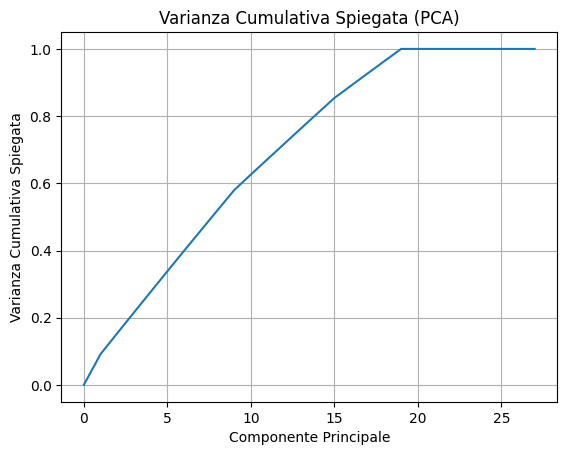

In [10]:
# Inizializzazione oggetto PCA
pca = PCA()
# "Fit" dell'oggetto PCA
X_trainval_pca = pca.fit_transform(X_trainval)
X_test_pca = pca.transform(X_test)

# Calcoliamo la varianza spiegata cumulativa
expld_variance = np.insert(np.cumsum(pca.explained_variance_ratio_), 0, 0)

# Creiamo il grafico della varianza cumulativa
plt.figure()
plt.plot(expld_variance)
plt.title('Varianza Cumulativa Spiegata (PCA)')
plt.xlabel('Componente Principale')
plt.ylabel('Varianza Cumulativa Spiegata')

# Impostiamo i ticks sugli assi x in base al numero di componenti principali
#ticks = np.arange(1, pca_global.n_components_ + 1, step=1)
#plt.xticks(ticks, labels=[f'PC{i}' for i in ticks], rotation=30)

plt.grid()
plt.show()

In [11]:
#explvar_p = 0.99

#pca = PCA(explvar_p)
#pca.fit(X_trainval)

#df_pca = pd.DataFrame({'val': [pca.n_components_, pca.explained_variance_ratio_.sum()]}, index=['n. PC', 'expl. Var. (%)'])
#display(df_pca)

In [13]:
#LDA sui dati ridotti dalla PCA
lda = LDA()
lda_pca = LDA()

lda.fit(X_trainval, y_trainval)
lda_pca.fit(X_trainval_pca, y_trainval)

y_pred = lda.predict(X_test)
y_pred_pca = lda_pca.predict(X_test_pca)

y_pred_proba = lda.predict_proba(X_test)
y_pred_pca_proba = lda_pca.predict_proba(X_test_pca)

scores_dict = {'Training Set': lda.score(X_trainval, y_trainval), 'Test Set': lda.score(X_test, y_test)}
scores = pd.DataFrame(scores_dict, index=['Accuracy'])

scores_dict_pca = {'Training Set': lda_pca.score(X_trainval_pca, y_trainval), 'Test Set': lda.score(X_test_pca, y_test)}
scores_pca = pd.DataFrame(scores_dict_pca, index=['Accuracy_pca'])

#y_pred_df = pd.DataFrame({'Pred. Class': y_pred, 
#                          'P(Class 0) - %': np.round(y_pred_proba[:, 0] * 100, decimals=2), 
#                          'P(Class 1) - %': np.round(y_pred_proba[:, 1] * 100, decimals=2), 
#                          'P(Class 2) - %': np.round(y_pred_proba[:, 2] * 100, decimals=2),
#                          'P(Class 3) - %': np.round(y_pred_proba[:, 3] * 100, decimals=2),
#                          'P(Class 4) - %': np.round(y_pred_proba[:, 4] * 100, decimals=2)
#                         })
#y_pred_df_pca = pd.DataFrame({'Pred. Class': y_pred_pca, 
#                          'P(Class 0) - %': np.round(y_pred_pca_proba[:, 0] * 100, decimals=2), 
#                          'P(Class 1) - %': np.round(y_pred_pca_proba[:, 1] * 100, decimals=2), 
#                          'P(Class 2) - %': np.round(y_pred_pca_proba[:, 2] * 100, decimals=2),
#                          'P(Class 3) - %': np.round(y_pred_pca_proba[:, 3] * 100, decimals=2),
#                          'P(Class 4) - %': np.round(y_pred_pca_proba[:, 4] * 100, decimals=2)
                             })

display(scores)
display(scores_pca)

#display(y_pred_df)
display(y_pred_df_pca)

display(y_pred_proba)

IndexError: index 4 is out of bounds for axis 1 with size 4